In this project, we develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.


### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [ ]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [ ]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

11501568/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[TO COMPLETE]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [ ]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean, z_var = inputs
        epsilon = tf.keras.backend.random_normal(tf.shape(z_mean), mean = 0.0, stddev = 1)
        z = z_mean + tf.math.exp(z_var/2)*epsilon
        
        return z
        # ...

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. Insert motivations about your choice into the tex cell below.

In [ ]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))

x = tf.keras.layers.Dense(256, activation = "relu")(encoder_inputs) #[TO COMPLETE]
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(128, activation = "relu")(x)
x = tf.keras.layers.Dense(64, activation = "relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)  #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

print(INPUT_DIM)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          32896       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                            

**Answer:** [TO COMPLETE]

For the **Number of layers**, i experimented with 1, 2 and 3 hidden layers and it was found that 3 hidden layers provide significantly better results than 1 and 2 hidden layers. And not significantly worse than more hidden layers. Therefore, 3 hidden layers seem to be a good balance.

**Layer sizes**: As for the Layer sizes, it was noted that a gradual decline in the layer sizes gives better performance than a very steep initial decline. For example, i first tried the first hidden layer with 128 units, then 64 and 32. This is significant drop of units from the input layer that has 784 units. However, experimenting with number of units showed that 256-128-64 units for the 3 hidden layers respectively gives better performance. 

**Activation Function:** For autoencoders, a non-linear activation function should be used. And from experience that was gained from Homework 5 and experimenting with different non-linear activation functions, it can be seen that relu performed slightly better than sigmoid and tanh in terms of the total loss. 


##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: Define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation = 'relu')(latent_inputs) #[COMPLETE]
#...[TO COMPLETE]...
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)

decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation = 'sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 784)               201488    
                                                                 
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_________________________________________________________________


**Answer:** [TO COMPLETE]

As the decoder is meant to mimic the encoder but in reverse order, in an hour glass shape, the same values were used for the number of layers, the layer sizes, and the activation function (but in reverse order for the layer sizes). Therefore, the same relu activation fuction was used as well. Other activation functions were experiemented with but the relu produced the best performance. 

However, for the last layer ("decoder_outputs") sigmoid was used as the activation function. This is because the output needs to be the same as the input, and in this hw the input is normalised to a range of 0 to 1. Therefore, the output needs to also be in a range from 0 to 1. This rules out relu and tanh from being used due to their range. The only suitable activation to be used that has a range from 0 to 1 is the sigmoid activation function for this case.

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            #[TO COMPLETE]
            reconstruction_loss = INPUT_DIM * tf.keras.losses.binary_crossentropy(data, reconstruction)  
            reconstruction_loss = tf.reduce_mean(reconstruction_loss)

            #[TO COMPLETE]
            kl_loss = tf.reduce_sum(-0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var)), axis = 1)
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 9s 6ms/step - loss: 196.1530 - reconstruction_loss: 191.7244 - kl_loss: 4.4286
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 165.7599 - reconstruction_loss: 160.8334 - kl_loss: 4.9266
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 159.3254 - reconstruction_loss: 154.0413 - kl_loss: 5.2841
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 155.9799 - reconstruction_loss: 150.4572 - kl_loss: 5.5227
Epoch 5/30
469/469 [==============================] - 4s 7ms/step - loss: 153.0812 - reconstruction_loss: 147.3797 - kl_loss: 5.7016
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 151.7043 - reconstruction_loss: 145.8782 - kl_loss: 5.8261
Epoch 7/30
469/469 [==============================] - 3s 7ms/step - loss: 150.2941 - reconstruction_loss: 144.3736 - kl_loss: 5.9205
Epoch 8/30
469/469 [==============================] - 3s 6ms/step - l

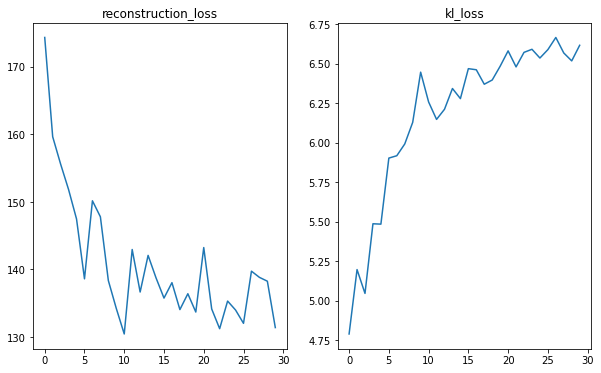

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

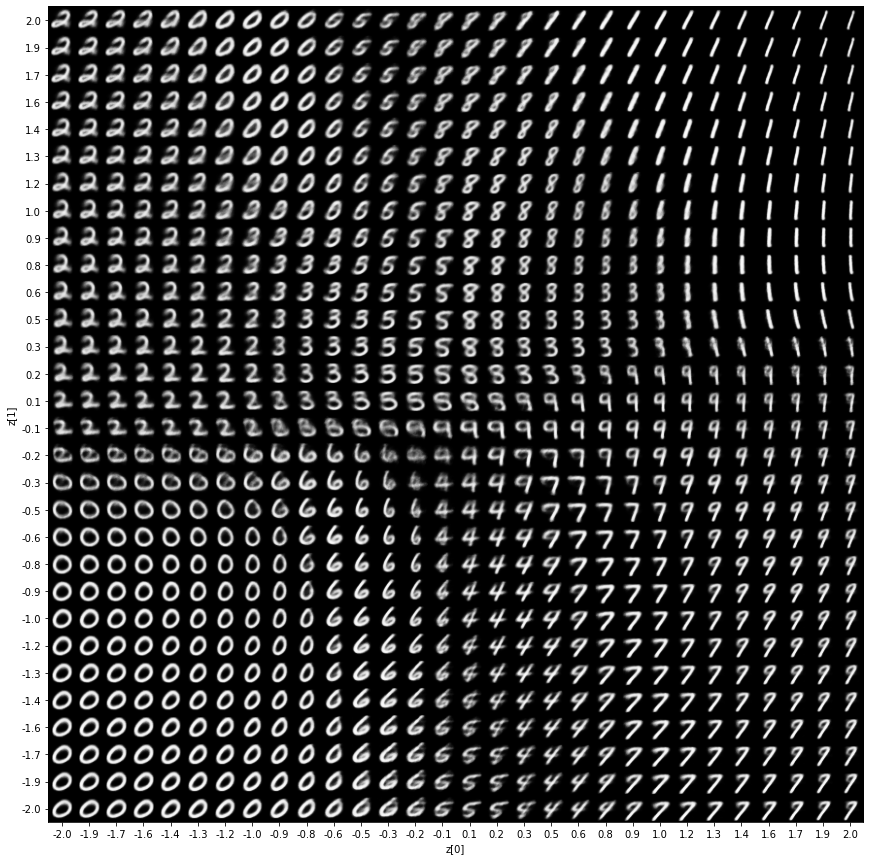

In [ ]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore what happens with different "scales"

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

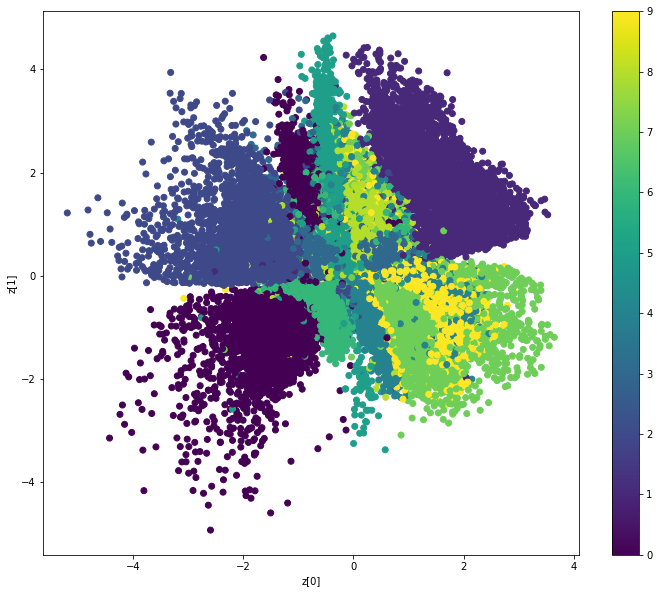

In [ ]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**Answer:** [TO COMPLETE}
Exploring what happens with different "scale" values. 
When the scale value is increased too much, for example to 5, 6, 7, etc. the digits produced are blurry. This is probably due to the fact that a large scale value allows sampling to be done beyond the boundaries of the clusters in the latent space. Therefore, since this is like unforseen territory for the model it is not able to produce a proper and clear digit. Lower scale values seem to provide less blurry digits but if it reduced to very small numbers like 0.1, 0.2, etc then the model produces fewer digits. Scale = 2.0 seems to be a balance of clarity of the digits and the number of digits produced.


**Discussion of the plots:**
Looking at the first plot figure of the digits, it can be seen that most digits were reproduced properly and distinctively, especially the ones on the edges of the plot. There's are certain noticeable regions in the plot where it can be seen that the digits seem morphed and are a combination of 2 different digits. This can be explained by looking at the latent space plot.

On the latent space plot, it can be seen that the different clusters  are overlapping on some regions. When samples are taken from the overlapping cluster regions of the latent space, that is when morphed data is produced. This is also why a smooth transition can be seen from one digit to another as latent space is sampled from one cluster to another. It can also be noted that the latent space is evenly distributed and does not have much gaps between the clusters. This is due to the unit norm condition of the input data.

Now to explore how the hyper-parameters of the VAE influece the final results:

**Changing the number of layers -**  

Increasing the number of hidden layers produces better results in terms of seperation of the digits. This can also be seen on the latent space plot where , eventhough, the clusters are next to each other without much gap between them, there is less overlapping between the different clusters. 

Decreasing the number of hidden layers has the opposite effect where more morphed digits are produced. This is apparent from the latent space plot that shows more overlapping clusters. This suggests that the encoder is able to capture the important information from the input data distrution much better and therefore produces better mean values of z that are more distinguishable.

 A slight difference can also be noticed in the toal loss. Increasing the number of hidden layers results in a slightly lower total loss while decreasing it results in a slightly higher total loss.


**Changing the layer sizes (number of units) -**  

Similar to the number of layers, increasing the number of units improved the results in terms of digit seperation and clarity. Initally starting from 128-64-32 and then moving to 256-128-64 and 512-256-128 for the encoder(in reverser for the decoder). The latent space for each group of number of units were significantly different from each other. It was noticed that there was lesser overlap between the different cluster bounderies in the latent space plots, i.e. showing better and clearer cluster bounderies. This, again, implies that the encoder is able capture the distribution and important information on the input data better and therefore generate better z-mean values compared to when the number of units is decreased. 

A slight difference can also be noticed in the toal loss. Increasing the number of units results in a slightly lower total loss while decreasing it results in a slightly higher total loss.

**Changing the activation function -** 

As explained in exercise 6.2, among the non-linear activation functions, it was noticed that for the activation function in the dense layers of both the encoder and the decoder, relu performed better than sigmoid and tanh in terms of the total loss. Even though its hard to distinguish for sure, looking at the latent space plot it seems that relu produces the clearest and most well defined cluster boundaries. 

The ReLu activation fucntion should also be the least computational heavy out of the three because its the simplest function. Although, this was not apparent when looking at the runtimes of the algorithms, if used in more complex models with many more layers and data, reLu should perform faster than the other two.

